* Task: classify image to its fruit type
* Get data from https://www.kaggle.com/moltean/fruits

In [10]:
import sys
print(sys.version)

from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


## Load data

In [4]:
train_path = './data/fruits-360-small/Training'
valid_path = './data/fruits-360-small/validation'

In [32]:
train_image_files = glob(train_path+'/*/*.jp*g')
valid_image_files = glob(valid_path+'/*/*.jp*g')

# get all folders under train_path
# since the number of folders equal to number of classes, we can get number of classes by len(folders)
folders = glob(train_path+'/*')

In [33]:
print(folders)

['./data/fruits-360-small/Training/Apple Golden 1', './data/fruits-360-small/Training/Avocado', './data/fruits-360-small/Training/Banana', './data/fruits-360-small/Training/Kiwi', './data/fruits-360-small/Training/Lemon', './data/fruits-360-small/Training/Mango', './data/fruits-360-small/Training/Raspberry', './data/fruits-360-small/Training/Strawberry']


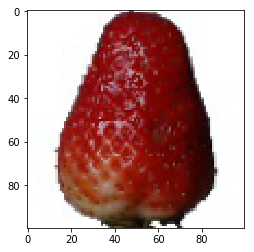

In [34]:
# look at a random image
plt.imshow(image.load_img(np.random.choice(train_image_files)))
plt.show()

## Construct Model

In [52]:
vgg = VGG16(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False
    
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [53]:
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

In [50]:
IMAGE_SIZE = [100, 100]
epochs = 5
batch_size = 32

In [38]:
gen = ImageDataGenerator(
rotation_range=20,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
vertical_flip=True,
preprocessing_function=preprocess_input
)

In [39]:
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)

Found 1207 images belonging to 8 classes.
{'Apple Golden 1': 0, 'Avocado': 1, 'Banana': 2, 'Kiwi': 3, 'Lemon': 4, 'Mango': 5, 'Raspberry': 6, 'Strawberry': 7}


In [40]:
labels = [None] * len(test_gen.class_indices)

In [41]:
print(labels)

[None, None, None, None, None, None, None, None]


In [42]:
for k, v in test_gen.class_indices.items():
    labels[v] = k

In [43]:
print(labels)

['Apple Golden 1', 'Avocado', 'Banana', 'Kiwi', 'Lemon', 'Mango', 'Raspberry', 'Strawberry']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -123.31439 max: 151.061


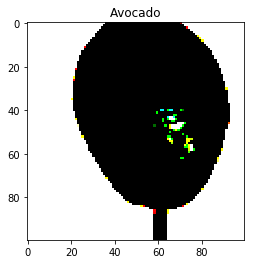

In [44]:
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [45]:
# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 3593 images belonging to 8 classes.
Found 1207 images belonging to 8 classes.


In [46]:
print(len(train_image_files)//batch_size)
print(len(valid_image_files)//batch_size)

112
37


In [54]:
r = model.fit_generator(
    generator=train_generator, 
    validation_data=valid_generator,
    steps_per_epoch=len(train_image_files)//batch_size,
    validation_steps=len(valid_image_files)//batch_size,
    epochs=epochs
    )

Epoch 1/5
112/112 [==============================] - 686s 6s/step - loss: 2.7886 - acc: 0.8139 - val_loss: 1.2725 - val_acc: 0.9037
Epoch 2/5
112/112 [==============================] - 733s 7s/step - loss: 1.1298 - acc: 0.9263 - val_loss: 1.1107 - val_acc: 0.9299
Epoch 3/5
112/112 [==============================] - 728s 7s/step - loss: 1.1250 - acc: 0.9286 - val_loss: 1.1176 - val_acc: 0.9282
Epoch 4/5
112/112 [==============================] - 735s 7s/step - loss: 1.1163 - acc: 0.9298 - val_loss: 1.1259 - val_acc: 0.9274
Epoch 5/5
112/112 [==============================] - 711s 6s/step - loss: 1.1234 - acc: 0.9295 - val_loss: 1.1109 - val_acc: 0.9291


In [66]:
def get_confusion_matrix(data_path, N):
    predictions = []
    targets = []
    i=0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size*2):
        i+=1
        if i % 20 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions=np.concatenate((predictions, p))
        targets=np.concatenate((targets, y))
        if len(targets) >= N:
            break;   
    cm = confusion_matrix(targets, predictions)
    return cm

In [67]:
cm = get_confusion_matrix(train_path, len(train_image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Found 3593 images belonging to 8 classes.
20
40
[[492   0   0   0   0   0   0   0]
 [  0 426   0   0   0   1   0   0]
 [  0   0 490   0   0   0   0   0]
 [  0   0   0 466   0   0   0   0]
 [244   0   2   0   0   0   0   0]
 [  0   3   0   0   0 487   0   0]
 [  0   0   0   0   0   0 490   0]
 [  0   0   0   0   0   0   0 492]]
Found 1207 images belonging to 8 classes.
[[164   0   0   0   0   0   0   0]
 [  0 140   0   0   0   3   0   0]
 [  0   0 166   0   0   0   0   0]
 [  0   0   0 156   0   0   0   0]
 [ 82   0   0   0   0   0   0   0]
 [  0   0   0   0   0 166   0   0]
 [  0   0   0   0   0   0 166   0]
 [  0   0   0   0   0   0   0 164]]


## Reference

* [Confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)